**Anharmonic oscillator**

extracting first excited state of harmonic oscillator with Metropolis algorithm

In [1]:
import numpy as np
from numpy.random import uniform 
import matplotlib.pyplot as plt

**parameters and arrays**

definition of the parameters

In [2]:
N=20
N_cor = 20
N_cf = 10000
N_stat=100
a = .5
epsilon = 1.4
m=1

arrays allocation

In [3]:
x = np.zeros((N,),np.float64)
G = np.zeros((N_cf,N),np.float64)
G_avgs=np.zeros((N,N_stat),np.float64)
G_sim=np.zeros((N_stat,N_cf,N),np.float64)

**dS**

with only the terms concerning a certain x_i

In [4]:
def S(i,x,m,a):
    i_p = (i+1)%len(x)    # next site
    i_m = (i-1)%len(x)    # previous site
    return a*((x[i])**4)/2 + x[i]*(x[i]-x[i_p]-x[i_m])*(m/a)

**Metropolis sweep**

In [5]:
#Metropolis sweep 
def update(x,m,a,epsilon):
    accept=0
    
    for i in range(len(x)):
        x_old=x[i]
        S_old=S(i,x,m,a)
        
        noise=uniform(-epsilon,epsilon)
        x[i]+=noise
        S_new=S(i,x,m,a)
        dS= S_new-S_old
        
        if dS > 0 and np.exp(-dS)<uniform(0,1):
            x[i]=x_old
        else:
            accept += 1
            
    return accept/len(x)

**compute G_n**

In [6]:
def computeG(x,n): #compute G_n
    g=0
    #N=len(x)
    for i in range(N):
        g+=x[i]*x[(i+n)%N]
    return g/N

**Monte Carlo average**

In [7]:
def MCaverage(x,G,N_corr,N_cf):
    #N=len(x)
    accepted=0
    for j in range(10*N_corr):
        update(x,m,a,epsilon)
    accepted=accepted/(10*N_corr)
    for alpha in range(N_cf):
        for i in range(N_corr):
            accepted+=update(x,m,a,epsilon)
        for n in range(N):
            G[alpha][n] = computeG(x,n)
    accepted=accepted/(N_cf*N_corr)
    
    #bootstrap copies and averages
    G_sim[0]=G
    for k in range(1,N_stat):
        G_sim[k]=bootstrap(G)
        
    for k in range(N_stat):
        for n in range(N):
            avg=0
            for alpha in range(N_cf):
                G_avgs[n][k]+=G_sim[k][alpha][n]
            G_avgs[n][k]=G_avgs[n][k]/N_cf
    
    return G_avgs,accepted

**DeltaE**

calculation and statistical analysis

In [8]:
def DeltaE(G_avgs):
    energy=np.zeros((N-1,N_stat),np.float64)
    time=np.zeros(N-1,np.float64)
    for k in range(N_stat):
        for n in range(N-1):
            energy[n][k] =np.log(np.abs(G_avgs[n][k]/G_avgs[n+1][k]))/a
            #np.log(np.divide(G_avgs[:-1],G_avgs[1:]))
            time[n]=n*a

    return energy,time

In [9]:
def stat_analysis(dE):
    
    mean_dE=np.zeros(N-1,np.float64)
    mean_dE_square=np.zeros(N-1,np.float64)
    error_dE=np.zeros(N-1,np.float64)
    
    for n in range(N-1):
        for k in range(N_stat):
            mean_dE[n]+=dE[n][k]
            mean_dE_square[n]+=(dE[n][k])**2
        mean_dE[n]=mean_dE[n]/N_stat
        mean_dE_square[n]=mean_dE_square[n]/N_stat
        error_dE[n]=((mean_dE_square[n]-(mean_dE[n])**2))**(1/2)
    return mean_dE,error_dE

**Bootstrap function**

In [10]:
def bootstrap(G): 
    #N_cf = len(G)
    G_bootstrap = [] # new ensemble
    for i in range(0,N_cf):
        alpha = int(uniform(0,N_cf))
        G_bootstrap.append(G[alpha]) 
    return G_bootstrap

array allocation for energy analysis

In [11]:
DE=np.zeros((N-1,N_stat),np.float64)
mean_DE=np.zeros(N-1,np.float64)
error_DE=np.zeros(N-1,np.float64)
t=np.zeros(N-1,np.float64)

MC simulation and energy analysis

In [12]:
MC_avg=0
accept_rate=0

MC_avg,accept_rate=MCaverage(x,G,N_cor,N_cf)
DE,t=DeltaE(MC_avg)
mean_DE,error_DE=stat_analysis(DE)
print("acceptance rate: "+str(accept_rate))

acceptance rate: 0.48439374999998747


**plotting**

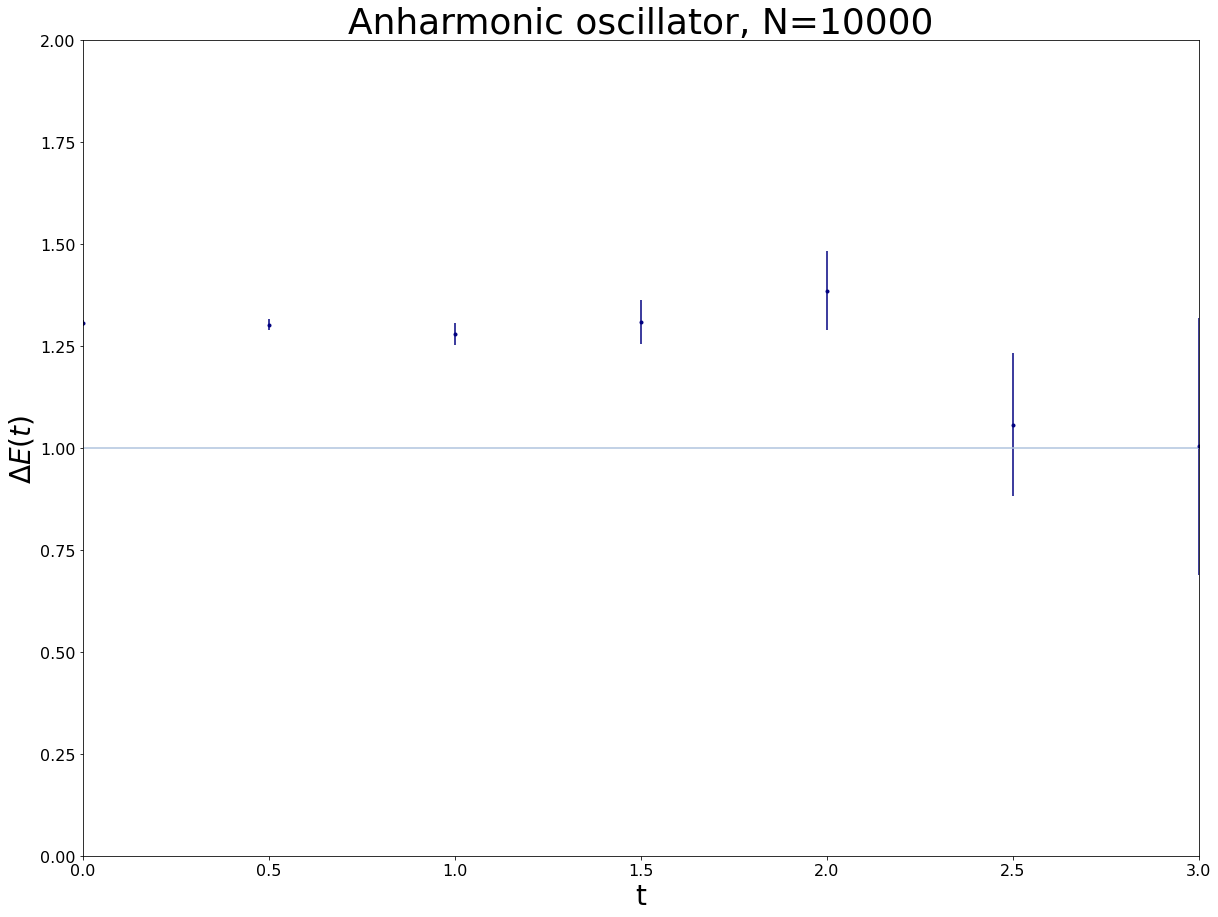

In [13]:
plt.figure(figsize=(20,15)) # 10 is width, 10 is height
plt.title('Anharmonic oscillator, N='+str(N_cf),fontsize=36)
plt.errorbar(t,mean_DE,yerr=error_DE,fmt='.',color='navy',label='numeric')
plt.xlabel(r"t",fontsize=28)
plt.ylabel(r"$\Delta E(t)$",fontsize=28)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0,3,0,2])
plt.axhline(y=1, color='lightsteelblue', linestyle='-')

plt.show()